In [1]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers import LSTM

execfile('midi_to_state.py')
daft_state = midiToNoteStateMatrix('daft_punk-one_more_time.mid')
len(daft_state)

Using Theano backend.
Using gpu device 0: GRID K520 (CNMeM is disabled, cuDNN Version is too old. Update to v5, was 2000.)


2401

In [12]:
def encode_midi_states(state_mat):
    chord_to_idx = {}
    idx_to_chord = {}
    for sixteenth_note in state_mat:
        notes_only = [note[0] for note in sixteenth_note]
        holds_only = [note[1] for note in sixteenth_note]
        note_idcs_set = tuple([i for i, x in enumerate(notes_only) if x == 1])
        holds_idcs_set = tuple([int(x == 1) for i, x in enumerate(holds_only) if i in note_idcs_set])
        combined_set = note_idcs_set + holds_idcs_set
        if len(combined_set) == 0:
            combined_set = (None)
        if not combined_set in chord_to_idx.keys():
            new_idx = len(chord_to_idx) + 1
            chord_to_idx[combined_set] = new_idx
            idx_to_chord[new_idx] = combined_set
    return [chord_to_idx, idx_to_chord]

results = encode_midi_states(daft_state)
print (len(results[0]))
print (len(results[1]))
chord_to_idx = results[0]
idx_to_chord = results[1]
chord_to_idx.keys()[4]

511
511


(6, 18, 28, 33, 37, 40, 45, 46, 49, 50, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0)

In [13]:
import random
randnum = random.sample(range(len(results[0])),1)[0]
print randnum
assert(results[0][results[1][randnum]] == randnum)

310


In [18]:
# now the set of chords is a library of possible classes
# return a num_notes x len_chord_set
def encode_song(midi_states, chord_to_idx):
    song_encoded = np.zeros((len(midi_states)+1, len(chord_to_idx)+1))
    for index, sixteenth_note in enumerate(midi_states):
        notes_only = [note[0] for note in sixteenth_note]
        holds_only = [note[1] for note in sixteenth_note]
        note_idcs_set = tuple([i for i, x in enumerate(notes_only) if x == 1])
        holds_idcs_set = tuple([int(x == 1) for i, x in enumerate(holds_only) if i in note_idcs_set])
        combined_set = note_idcs_set + holds_idcs_set
        if len(combined_set) == 0: combined_set = (None)
        library_idx = chord_to_idx[combined_set]
        song_encoded.itemset((index,library_idx), 1)
    return song_encoded

encoded_song = encode_song(daft_state, chord_to_idx)
len(encoded_song)

2402

In [19]:
randnum = random.sample(range(len(encoded_song)),1)[0]
print randnum
assert(sum(encoded_song[randnum]) == 1)

1459


In [20]:
maxlen = 40
step = 3
chunks = []
next_chords = []
for i in range(0, len(encoded_song) - maxlen, step):
    chunks.append(encoded_song[i: i + maxlen])
    next_chords.append(encoded_song[i + maxlen])

# len(chunks) should == len(daft_state)/step
assert(len(chunks) == len(next_chords))

X = np.array(chunks)
y = np.array(next_chords)
print(X.shape)
print(y.shape)
print(sum(y[0]))

(788, 40, 512)
(788, 512)
1.0


In [21]:
# build the model: 2 stacked LSTM
print('Build model...')
model = Sequential()
model.add(LSTM(512, return_sequences=True, input_shape=(maxlen, len(chord_to_idx)+1)))
model.add(Dropout(0.2))
model.add(LSTM(512, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(len(chord_to_idx)+1))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

Build model...


In [22]:
hist = model.fit(X, y, batch_size=128, nb_epoch=20)
print hist.history

Epoch 1/20
788/788 [==============================] - 2s - loss: 5.8831 - acc: 0.0368     
Epoch 2/20
788/788 [==============================] - 2s - loss: 5.2075 - acc: 0.0558     
Epoch 3/20
788/788 [==============================] - 2s - loss: 5.0401 - acc: 0.0647     
Epoch 4/20
788/788 [==============================] - 2s - loss: 4.9161 - acc: 0.0685     
Epoch 5/20
788/788 [==============================] - 2s - loss: 4.7944 - acc: 0.0914     
Epoch 6/20
788/788 [==============================] - 2s - loss: 4.7421 - acc: 0.0863     
Epoch 7/20
788/788 [==============================] - 2s - loss: 4.6423 - acc: 0.0939     
Epoch 8/20
788/788 [==============================] - 2s - loss: 4.4988 - acc: 0.1193     
Epoch 9/20
788/788 [==============================] - 2s - loss: 4.4762 - acc: 0.1079     
Epoch 10/20
788/788 [==============================] - 2s - loss: 4.3143 - acc: 0.1371     
Epoch 11/20
788/788 [==============================] - 2s - loss: 4.2643 - acc: 0.1358   

In [12]:
# build the model: 2 stacked LSTM
print('Build model...')
model = Sequential()
model.add(LSTM(512, return_sequences=True, input_shape=(maxlen, len(chord_to_idx)+1)))
model.add(Dropout(0.2))
model.add(LSTM(512, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(512, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(len(chord_to_idx)+1))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

Build model...


In [13]:
model.fit(X, y, batch_size=128, nb_epoch=20)

Epoch 1/20
788/788 [==============================] - 3s - loss: 5.5798 - acc: 0.0495     
Epoch 2/20
788/788 [==============================] - 3s - loss: 5.0820 - acc: 0.0457     
Epoch 3/20
788/788 [==============================] - 3s - loss: 4.8778 - acc: 0.0660     
Epoch 4/20
788/788 [==============================] - 3s - loss: 4.8023 - acc: 0.0571     
Epoch 5/20
788/788 [==============================] - 3s - loss: 4.7255 - acc: 0.0635     
Epoch 6/20
788/788 [==============================] - 3s - loss: 4.7584 - acc: 0.0393     
Epoch 7/20
788/788 [==============================] - 3s - loss: 4.6553 - acc: 0.0635     
Epoch 8/20
788/788 [==============================] - 3s - loss: 4.6480 - acc: 0.0673     
Epoch 9/20
788/788 [==============================] - 3s - loss: 4.6178 - acc: 0.0647     
Epoch 10/20
788/788 [==============================] - 3s - loss: 4.6676 - acc: 0.0470     
Epoch 11/20
788/788 [==============================] - 3s - loss: 4.6109 - acc: 0.0736   

In [37]:
hidden_sizes = [10,100,200,300,500,1000]
epochs = 100
results = {}
for size in hidden_sizes:
    print('Build model...')
    model = Sequential()
    model.add(LSTM(size, return_sequences=True, input_shape=(maxlen, len(chord_to_idx)+1)))
    model.add(Dropout(0.2))
    model.add(LSTM(size, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(len(chord_to_idx)+1))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    hist = model.fit(X, y, batch_size=128, nb_epoch=epochs, verbose=0)
    results[size] = hist


Build model...
Build model...
Build model...
Build model...
Build model...
Build model...


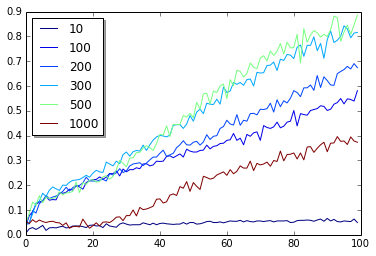

In [38]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

xran = xrange(0,epochs)
norm = colors.Normalize(min(hidden_sizes), max(hidden_sizes))

for size in hidden_sizes:
    color = cm.jet(norm(size))
    plt.plot(xran, results[size].history['acc'], 'b-', label=str(size), color = color)

legend = plt.legend(loc='upper left', shadow=True)    
plt.show()

In [7]:
maxlen = 40
step = 1
chunks = []
next_chords = []
for i in range(0, len(encoded_song) - maxlen, step):
    chunks.append(encoded_song[i: i + maxlen])
    next_chords.append(encoded_song[i + maxlen])

# len(chunks) should == len(daft_state)/step
assert(len(chunks) == len(next_chords))

X = np.array(chunks)
y = np.array(next_chords)
print(X.shape)
print(y.shape)
print(sum(y[0]))


(2362, 40, 382)
(2362, 382)
1.0


In [8]:
# build the model: 2 stacked LSTM
print('Build model...')
model = Sequential()
model.add(LSTM(512, return_sequences=True, input_shape=(maxlen, len(chord_to_idx)+1)))
model.add(Dropout(0.2))
model.add(LSTM(512, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(len(chord_to_idx)+1))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model.fit(X, y, batch_size=128, nb_epoch=20)

Build model...
Epoch 1/20
2362/2362 [==============================] - 6s - loss: 5.2425 - acc: 0.0533     
Epoch 2/20
2362/2362 [==============================] - 6s - loss: 4.6923 - acc: 0.0817     
Epoch 3/20
2362/2362 [==============================] - 6s - loss: 4.4990 - acc: 0.1050     
Epoch 4/20
2362/2362 [==============================] - 6s - loss: 4.1817 - acc: 0.1490     
Epoch 5/20
2362/2362 [==============================] - 6s - loss: 3.9541 - acc: 0.1541     
Epoch 6/20
2362/2362 [==============================] - 6s - loss: 3.7840 - acc: 0.1664     
Epoch 7/20
2362/2362 [==============================] - 6s - loss: 3.6223 - acc: 0.1960     
Epoch 8/20
2362/2362 [==============================] - 6s - loss: 3.5039 - acc: 0.1926     
Epoch 9/20
2362/2362 [==============================] - 6s - loss: 3.3428 - acc: 0.2036     
Epoch 10/20
2362/2362 [==============================] - 6s - loss: 3.2240 - acc: 0.2185     
Epoch 11/20
2362/2362 [==============================]

In [23]:
import sys
generated_length = 400

def sample(a, temperature=1.0):
    # helper function to sample an index from a probability array
    a = np.log(a) / temperature
    a = np.exp(a) / np.sum(np.exp(a))
    return np.argmax(np.random.multinomial(1, a, 1))

start_index = random.randint(0, len(encoded_song) - maxlen - 1)
generated = np.zeros((generated_length+1, len(chord_to_idx)+1))
song_chunk = encoded_song[start_index: start_index + 1]
generated[0,:] = song_chunk

In [25]:
diversity = 1
for i in range(generated_length):
    x = np.zeros((1, maxlen, len(chord_to_idx)+1))
    for t, char in enumerate(song_chunk):
        if 1 in list(char):
            ind = list(char).index(1)
        else:
            ind = None
        x[0, t, ind] = 1.

    preds = model.predict(x, verbose=0)[0]
    next_index = sample(preds, diversity)
    next_chord = np.zeros((1,len(chord_to_idx)+1))
    next_chord.itemset((0,next_index), 1)

    generated[i,:] = next_chord
    song_chunk = next_chord

print()

()


In [28]:
#np.array(generated).shape

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0

In [30]:
def generated_sequence_to_midi_state(one_hot_chords):
    # takes a matrix of vectors, and uses idx_to_chords to get the chords set
    midi_states = []
    # find index of 1 in each one_hot_chord    
    for one_hot in one_hot_chords:
        note_state = np.zeros((len(daft_state[0]), 2))
        if 1 in one_hot:
            chord_set_idx = list(one_hot).index(1)
        else:
            chord_set_idx = chord_to_idx[(None)]
        notes_in_chord = idx_to_chord[chord_set_idx]
        if notes_in_chord is not None:
            mid = (len(notes_in_chord)/2)
            notes = notes_in_chord[0:mid]
            holds = notes_in_chord[mid:len(notes_in_chord)]
            for i, note in enumerate(notes):
                note_state.itemset((note, 0), 1)
                was_held = holds[i] == 1
                if was_held: note_state.itemset((note, 1), 1)
        midi_states.append(note_state)
    return midi_states


In [34]:
res = generated_sequence_to_midi_state(generated)

[[ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 1.  1.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 1.  1.]
 [ 1.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 1.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 1.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 1.  1.]
 [ 1.  1.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 1.  1.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]]


In [35]:
execfile('midi_to_state.py')

In [36]:
mid = noteStateMatrixToMidi(res)

In [45]:
len(model.get_weights())

26